In [2]:
%pip install tensorflow keras opencv-python matplotlib numpy


Note: you may need to restart the kernel to use updated packages.


Found 1744 images belonging to 3 classes.
Found 434 images belonging to 3 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


c:\Users\35846\anaconda3\envs\labelstudio\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 0.7390 - loss: 0.0753

c:\Users\35846\anaconda3\envs\labelstudio\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\35846\anaconda3\envs\labelstudio\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


55/55 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7399 - loss: 0.0751 - val_accuracy: 0.8018 - val_loss: 9.7756e-05
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8091 - loss: 0.1041 - val_accuracy: 0.8018 - val_loss: 2.0015e-04
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.7894 - loss: -0.1286 - val_accuracy: 0.8018 - val_loss: 4.6165e-05
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.7920 - loss: -0.0561 - val_accuracy: 0.8018 - val_loss: 1.1848e-04
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7832 - loss: 3.2400e-04 - val_accuracy: 0.8018 - val_loss: 7.8957e-05
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7988 - loss: -0.0449 - val_accuracy: 0.8018 - val_loss: -6.1686e-05
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7937 - loss: -0.0666 - val_accuracy: 0.8018 - val_loss: -1.5218e-04
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8016 - loss: 0.2522 - val_a

✅ Modell sparad som 'snowboard_vs_slalom_cnn.h5'


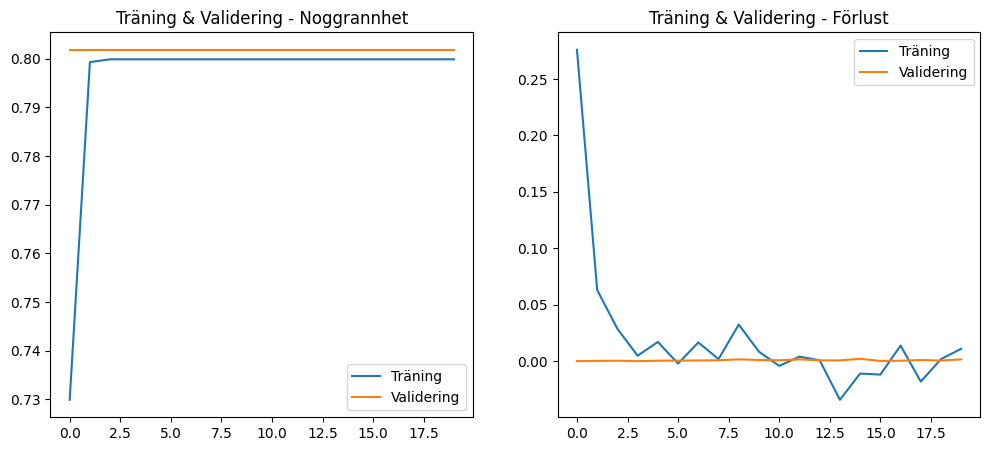

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# =============================
# 🔹 DATASET & FÖRBEARBETNING
# =============================

# Definiera datasetets sökvägar
DATASET_PATH = "dataset/"  # Struktur: dataset/snowboard/ och dataset/slalom/
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Använd ImageDataGenerator för att ladda och augmentera datasetet
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalisera pixelvärden
    rotation_range=20,  # Rotera bilder slumpmässigt
    width_shift_range=0.2,  # Flytta bilder horisontellt
    height_shift_range=0.2,  # Flytta bilder vertikalt
    shear_range=0.2,  # Skjuvning
    zoom_range=0.2,  # Zooma in och ut
    horizontal_flip=True,  # Spegelvändning
    validation_split=0.2  # Använd 20% av datasetet för validering
)

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",  # Använd "categorical" om fler än två klasser
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"
)

# =============================
# 🔹 MODELL: ÖVERFÖRINGSINLÄRNING MED EfficientNetB0
# =============================

# Ladda en förtränad EfficientNetB0 utan topp-lager
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Frys basmodellens lager så de inte tränas i första steget
base_model.trainable = False

# Lägg till egna lager ovanpå basmodellen
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling för att minska dimensioner
x = Dense(128, activation="relu")(x)  # Fullt anslutet lager
x = Dropout(0.3)(x)  # Dropout för att undvika överträning
predictions = Dense(1, activation="sigmoid")(x)  # Sigmoid eftersom vi har två klasser

# Skapa den slutliga modellen
model = Model(inputs=base_model.input, outputs=predictions)

# =============================
# 🔹 TRÄNINGSSTEG 1: ÖVERFÖRINGSINLÄRNING
# =============================

# Kompilera modellen
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="binary_crossentropy",  # Använd "categorical_crossentropy" om fler än två klasser
    metrics=["accuracy"]
)

# Träna modellen (första steget)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Träna först i 10 epoker
    verbose=1
)

# =============================
# 🔹 TRÄNINGSSTEG 2: FINJUSTERING (Fine-tuning)
# =============================

# Lås upp de sista 20 lagren för vidare träning
base_model.trainable = True
for layer in base_model.layers[:-20]:  
    layer.trainable = False  # Låt tidigare lager förbli låsta

# Kompilera igen med en lägre inlärningshastighet
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lägre LR för finjustering
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Träna modellen vidare
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # Ytterligare 20 epoker
    verbose=1
)

# =============================
# 🔹 SPARA MODELLEN
# =============================

model.save("snowboard_vs_slalom_cnn.h5")
print("✅ Modell sparad som 'snowboard_vs_slalom_cnn.h5'")

# =============================
# 🔹 VIZUALISERA TRÄNINGSRESULTAT
# =============================

def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    
    # Plotta träningens noggrannhet
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Träning")
    plt.plot(epochs_range, val_acc, label="Validering")
    plt.legend(loc="lower right")
    plt.title("Träning & Validering - Noggrannhet")

    # Plotta träningens förlustvärde
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Träning")
    plt.plot(epochs_range, val_loss, label="Validering")
    plt.legend(loc="upper right")
    plt.title("Träning & Validering - Förlust")

    plt.show()

plot_training(history_fine)


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# =========================
# 🔹 Ladda den tränade modellen
# =========================
MODEL_PATH = "snowboard_vs_slalom_cnn.h5"  # Se till att modellen finns i samma mapp
model = load_model(MODEL_PATH)

# =========================
# 🔹 Förbehandling av bildrutor
# =========================
IMG_SIZE = (224, 224)  # Bildstorlek måste matcha modellen

def preprocess_frame(frame):
    frame = cv2.resize(frame, IMG_SIZE)  # Ändra storlek
    frame = frame / 255.0  # Normalisera (0-1)
    frame = np.expand_dims(frame, axis=0)  # Lägg till batch-dimension
    return frame

# =========================
# 🔹 Ladda video och analysera varje bildruta
# =========================
VIDEO_PATH = "./data/video.mp4"  # Byt till din videofil
cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    print("⚠️ Fel: Kunde inte öppna videofilen!")
    exit()

# =========================
# 🔹 Läs och analysera varje bildruta
# =========================
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter("output.avi", fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

while True:
    ret, frame = cap.read()
    if not ret:
        break  # Avsluta om videon är slut

    processed_frame = preprocess_frame(frame)  # Förbered bilden
    prediction = model.predict(processed_frame)[0][0]  # Gör förutsägelse

    # Klassificering: 0 = Slalomåkare, 1 = Snowboardåkare
    label = "Snowboardåkare" if prediction > 0.5 else "Slalomåkare"
    confidence = int(prediction * 100) if prediction > 0.5 else int((1 - prediction) * 100)

    # =========================
    # 🔹 Rita ut resultatet på videobilden
    # =========================
    text = f"{label} ({confidence}%)"
    color = (0, 255, 0) if label == "Snowboardåkare" else (255, 0, 0)
    
    cv2.putText(frame, text, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    cv2.imshow("Video Klassificering", frame)

    out.write(frame)  # Spara bildrutan i filen


    # Tryck 'q' för att avsluta
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# =========================
# 🔹 Stäng allt när videon är klar
# =========================
cap.release()
out.release()
cv2.destroyAllWindows()
print("✅ Videoklassificering avslutad!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━